# 🚥 대구 Modeling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

In [ ]:
path1 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/data.csv'   #전처리한 데이터
path2 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/testdata.csv' #전처리한 데이터
path3 = '/content/drive/MyDrive/셩 코딩 연습/data/daegu/sample_submission.csv'

train = pd.read_csv(path1)
test = pd.read_csv(path2)
sub = pd.read_csv(path3)

In [ ]:
#컬럼 순서 train = test
test = test[['ID', '사고일시', '요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '연',
       '월', '일', '시간', '휴일', '누적월', '누적주', 'y-m', '도로형태1', '도로형태2']]

In [ ]:
print(f"train의 컬럼 : {train.columns}")
print(f"test의 컬럼 : {test.columns}")

train의 컬럼 : Index(['ID', '사고일시', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '도시', '구', '동', '연',
       '월', '일', '시간', '휴일', '누적월', '누적주', 'y-m', '도로형태1', '도로형태2'],
      dtype='object')
test의 컬럼 : Index(['ID', '사고일시', '요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '연', '월',
       '일', '시간', '휴일', '누적월', '누적주', 'y-m', '도로형태1', '도로형태2'],
      dtype='object')


In [ ]:
# train 및 test 시간 순서로 정렬하기
train = train.sort_values(by = ["사고일시"]).reset_index(drop= True)
test = test.sort_values(by = ["사고일시"]).reset_index(drop= True)

In [ ]:
#분석에 필요없는 컬럼 제거
train = train.drop(columns=['ID','y-m','도시'])
test = test.drop(columns=['ID','y-m','도시'])

### ✔︎ 추가 Feature Engineering
- Datetime
- Season

In [ ]:
#계절, 행락철 컬럼 만들어주기
train.loc[(train['월'] == 3) | (train['월'] == 4) | (train['월'] == 5), '계절'] = '1'     #봄
train.loc[(train['월'] == 6) | (train['월'] == 7) | (train['월'] == 8), '계절'] = '2'     #여름
train.loc[(train['월'] == 9) | (train['월'] == 10) | (train['월'] == 11), '계절'] = '3'   #가을
train.loc[(train['월'] == 12) | (train['월'] == 1) | (train['월'] == 2), '계절'] = '4'    #겨울


test.loc[(test['월'] == 3) | (test['월'] == 4) | (test['월'] == 5), '계절'] = '1'
test.loc[(test['월'] == 6) | (test['월'] == 7) | (test['월'] == 8), '계절'] = '2'
test.loc[(test['월'] == 9) | (test['월'] == 10) | (test['월'] == 11), '계절'] = '3'
test.loc[(test['월'] == 12) | (test['월'] == 1) | (test['월'] == 2), '계절'] = '4'

train.loc[(train['월'] == 3) | (train['월'] == 10) | (train['월'] == 11), '행락철'] = '1'
test.loc[(train['월'] == 3) | (test['월'] == 10) | (test['월'] == 11), '행락철'] = '1'

In [ ]:
train['사고일시'] = pd.to_datetime(train['사고일시'])
train['is_month_start'] = train['사고일시'].dt.is_month_start
train['is_month_end'] = train['사고일시'].dt.is_month_end
train['is_quarter_start'] = train['사고일시'].dt.is_quarter_start
train['is_quarter_end'] = train['사고일시'].dt.is_quarter_end
train['is_year_start'] = train['사고일시'].dt.is_year_start
train['is_year_end'] = train['사고일시'].dt.is_year_end
train['is_leap_year'] = train['사고일시'].dt.is_leap_year
train['dayofyear'] = train['사고일시'].dt.dayofyear

test['사고일시'] = pd.to_datetime(test['사고일시'])
test['is_month_start'] = test['사고일시'].dt.is_month_start
test['is_month_end'] = test['사고일시'].dt.is_month_end
test['is_quarter_start'] = test['사고일시'].dt.is_quarter_start
test['is_quarter_end'] = test['사고일시'].dt.is_quarter_end
test['is_year_start'] = test['사고일시'].dt.is_year_start
test['is_year_end'] = test['사고일시'].dt.is_year_end
test['is_leap_year'] = test['사고일시'].dt.is_leap_year
test['dayofyear'] = test['사고일시'].dt.dayofyear

### ✔︎ 인코딩

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
#행락철 아닌 날(NaN) 채워주기
train = train.fillna(0)
test = test.fillna(0)

In [ ]:
category_columns = ['계절','행락철']
train[category_columns] = train[category_columns].astype('int')
test[category_columns] = test[category_columns].astype('int')

In [ ]:
#Datetime 인코딩
category_columns = ['is_month_start', 'is_month_end', 'is_quarter_start','is_quarter_end','is_year_start','is_year_end','is_leap_year']
train[category_columns] = train[category_columns].astype('str')
test[category_columns] = test[category_columns].astype('str')

train = train.replace('True', 1)
train = train.replace('False',0)

test = test.replace('True', 1)
test = test.replace('False',0)

In [ ]:
#요일 -> 수치화
train['요일'] = train['요일'].map({'월요일':1,'화요일':2,'수요일':3,'목요일':4,'금요일':5,'토요일':6,'일요일':7})
test['요일'] = test['요일'].map({'월요일':1,'화요일':2,'수요일':3,'목요일':4,'금요일':5,'토요일':6,'일요일':7})

In [ ]:
# Mapping을 활용환 Ordinal Encoding(변수 순서 유지)
weather_dict = {"눈": 1, "맑음": 2, "흐림": 3, "비": 4, "기타":5, "안개":6}
ground_dict = {"적설": 1, "기타": 2, "서리/결빙": 3, "건조": 4, "젖음/습기":5, "침수":6 }
accident_dict = {"차대사람": 1, "차량단독": 2, "차대차": 3 }
way1_dict = {"주차장": 1, "미분류": 2, "기타": 3, "단일로": 4, "교차로":5 }
way2_dict = {"주차장": 1, "미분류": 2, "교차로횡단보도내": 3, "지하차도(도로)내": 4, "기타":5, "교차로부근":6
             ,"교차로안":7, "교량":8, "고가도로위":9, "터널":1}

train["기상상태_O"] = train['기상상태'].map(weather_dict)
train["노면상태_O"] = train['노면상태'].map(ground_dict)
train["사고유형_O"] = train['사고유형'].map(accident_dict)
train["도로형태1_O"] = train['도로형태1'].map(way1_dict)
train["도로형태2_O"] = train['도로형태2'].map(way2_dict)

test["기상상태_O"] = test['기상상태'].map(weather_dict)
test["노면상태_O"] = test['노면상태'].map(ground_dict)
test["사고유형_O"] = test['사고유형'].map(accident_dict)
test["도로형태1_O"] = test['도로형태1'].map(way1_dict)
test["도로형태2_O"] = test['도로형태2'].map(way2_dict)

In [ ]:
import category_encoders as ce
#상대적으로 많은 변수를 가진 구와 동은 binary encoding 기법을 통해 인코딩

encoder = ce.BinaryEncoder(cols=['구','동'])

train_binary = encoder.fit_transform(train[['구','동']])
train = pd.concat([train,train_binary],axis=1)

test_binary = encoder.fit_transform(test[['구','동']])
test = pd.concat([test,test_binary],axis=1)

In [ ]:
#인코딩 후 필요없는 컬럼 제거

train = train.drop(columns=['사고일시','요일', '기상상태', '노면상태', '사고유형', '구', '동', '도로형태1', '도로형태2'])
test = test.drop(columns=['사고일시','요일', '기상상태', '노면상태', '사고유형', '구', '동', '도로형태1', '도로형태2'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ECLO              39609 non-null  int64
 1   연                 39609 non-null  int64
 2   월                 39609 non-null  int64
 3   일                 39609 non-null  int64
 4   시간                39609 non-null  int64
 5   휴일                39609 non-null  int64
 6   누적월               39609 non-null  int64
 7   누적주               39609 non-null  int64
 8   계절                39609 non-null  int64
 9   행락철               39609 non-null  int64
 10  is_month_start    39609 non-null  int64
 11  is_month_end      39609 non-null  int64
 12  is_quarter_start  39609 non-null  int64
 13  is_quarter_end    39609 non-null  int64
 14  is_year_start     39609 non-null  int64
 15  is_year_end       39609 non-null  int64
 16  is_leap_year      39609 non-null  int64
 17  dayofyear         39609 non-nul

# 🚑 Modeling

In [ ]:
#데이터셋 분리
test_x = test
train_x = train.drop(columns=['ECLO']).copy()
train_y = train['ECLO'].copy()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):

    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

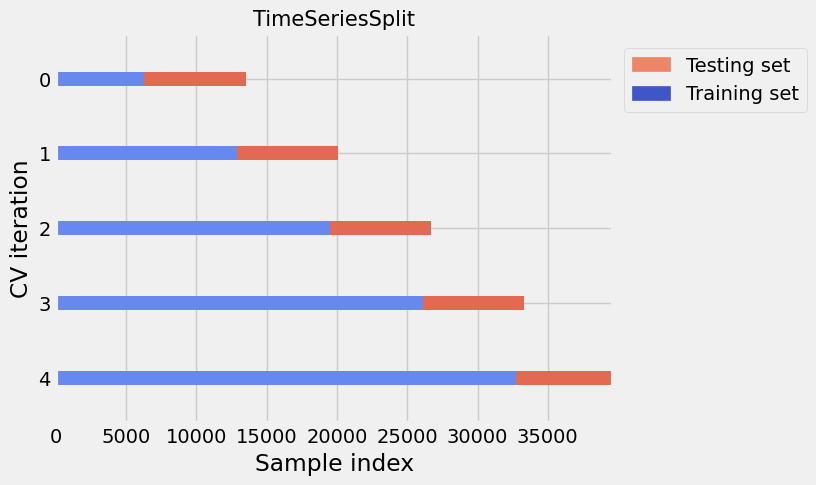

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


#5개의 훈련용+검증용 데이터셋을 만든다는 것을 의미
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, train, n_splits=n_split)
plt.show()

## 🐈 Cat

In [ ]:
# 모델 정의 및 훈련 예측
n_estimators =1000
lrs = 0.05
max_depths = 10
l2_leaf_reg = 3

cat = CatBoostRegressor(random_state = 42,
                                n_estimators = n_estimators,
                                learning_rate = lrs,
                                depth = max_depths,
                                l2_leaf_reg = l2_leaf_reg,
                                metric_period = 1000)

cat.fit(train_x, train_y)

sub['ECLO'] = cat.predict(test_x)
sub

0:	learn: 3.2013967	total: 58.6ms	remaining: 58.5s
999:	learn: 2.3860712	total: 41.1s	remaining: 0us


,ID,ECLO
0,ACCIDENT_39609,4.587088
1,ACCIDENT_39610,4.225213
2,ACCIDENT_39611,4.950229
3,ACCIDENT_39612,4.755905
4,ACCIDENT_39613,5.219632
...,...,...
10958,ACCIDENT_50567,4.650943
10959,ACCIDENT_50568,3.412931
10960,ACCIDENT_50569,6.074290
10961,ACCIDENT_50570,5.514477


In [ ]:
sub.to_csv('cat3.csv', index = False)

##🧬 XGBoost

In [ ]:
# 모델 학습
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1)
model.fit(train_x, train_y, verbose=1,cat_features=train_x.columns.tolist())

# 모델 학습
y_pred = model.predict(test_x)

0:	learn: 3.1998785	total: 37.5ms	remaining: 3.71s
1:	learn: 3.1939963	total: 59ms	remaining: 2.89s
2:	learn: 3.1894482	total: 83.3ms	remaining: 2.69s
3:	learn: 3.1861073	total: 110ms	remaining: 2.63s
4:	learn: 3.1827182	total: 134ms	remaining: 2.55s
5:	learn: 3.1797061	total: 166ms	remaining: 2.6s
6:	learn: 3.1778658	total: 183ms	remaining: 2.44s
7:	learn: 3.1763743	total: 193ms	remaining: 2.22s
8:	learn: 3.1746573	total: 233ms	remaining: 2.35s
9:	learn: 3.1730675	total: 280ms	remaining: 2.52s
10:	learn: 3.1719059	total: 315ms	remaining: 2.55s
11:	learn: 3.1706157	total: 355ms	remaining: 2.61s
12:	learn: 3.1695251	total: 392ms	remaining: 2.63s
13:	learn: 3.1687408	total: 442ms	remaining: 2.71s
14:	learn: 3.1687007	total: 495ms	remaining: 2.81s
15:	learn: 3.1678069	total: 537ms	remaining: 2.82s
16:	learn: 3.1669521	total: 579ms	remaining: 2.83s
17:	learn: 3.1660907	total: 627ms	remaining: 2.85s
18:	learn: 3.1654137	total: 672ms	remaining: 2.86s
19:	learn: 3.1642310	total: 724ms	remaini

In [ ]:
sample_submission = pd.read_csv(path3)
sample_submission['ECLO'] = y_pred
sample_submission.to_csv('xgb3.csv',index=False)
sample_submission

,ID,ECLO
0,ACCIDENT_39609,4.039567
1,ACCIDENT_39610,3.745583
2,ACCIDENT_39611,5.679230
3,ACCIDENT_39612,5.203218
4,ACCIDENT_39613,5.069782
...,...,...
10958,ACCIDENT_50567,5.133858
10959,ACCIDENT_50568,4.526340
10960,ACCIDENT_50569,5.032111
10961,ACCIDENT_50570,4.695160


##🚀 앙상블

In [ ]:
cat = pd.read_csv('cat3.csv')
xgb = pd.read_csv('xgb3.csv')

In [ ]:
df = pd.merge(cat, xgb, how= 'inner', on = 'ID')
df['ECLO'] = (df['ECLO_x'] + df['ECLO_y'])/2
df

,ID,ECLO_x,ECLO_y,ECLO
0,ACCIDENT_39609,4.587088,4.039567,4.313328
1,ACCIDENT_39610,4.225213,3.745583,3.985398
2,ACCIDENT_39611,4.950229,5.679230,5.314730
3,ACCIDENT_39612,4.755905,5.203218,4.979561
4,ACCIDENT_39613,5.219632,5.069782,5.144707
...,...,...,...,...
10958,ACCIDENT_50567,4.650943,5.133858,4.892401
10959,ACCIDENT_50568,3.412931,4.526340,3.969635
10960,ACCIDENT_50569,6.074290,5.032111,5.553201
10961,ACCIDENT_50570,5.514477,4.695160,5.104818


In [ ]:
df = df.drop(columns = ["ECLO_x","ECLO_y"])
df.to_csv('앙상블2.csv', index = False)
df

,ID,ECLO
0,ACCIDENT_39609,4.313328
1,ACCIDENT_39610,3.985398
2,ACCIDENT_39611,5.314730
3,ACCIDENT_39612,4.979561
4,ACCIDENT_39613,5.144707
...,...,...
10958,ACCIDENT_50567,4.892401
10959,ACCIDENT_50568,3.969635
10960,ACCIDENT_50569,5.553201
10961,ACCIDENT_50570,5.104818


## 모델 예측

In [ ]:
!pip install sktime

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

train data shape
x:(32409, 34), y:(32409,)


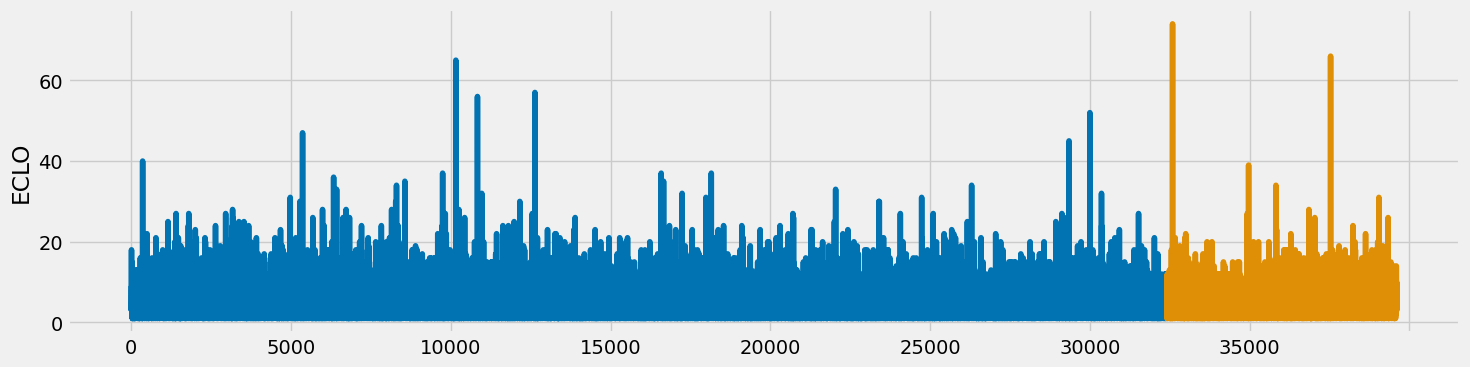

In [ ]:
## 7번 건물의 발전량
y = train['ECLO']
x = train.iloc[:, 1:]


y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 24*300) # 24시간*300일

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmsle',
    'max_depth': 5,
    'n_estimators': 100
}

xgb_reg = XGBRegressor(**params)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

y_pred = xgb_reg.predict(x_valid)

print('rmsle : {:.6f}'.format(np.sqrt(mean_squared_log_error(y_valid, y_pred))))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


rmsle : 0.438424


best iterations: 11
rmsle : 0.438424


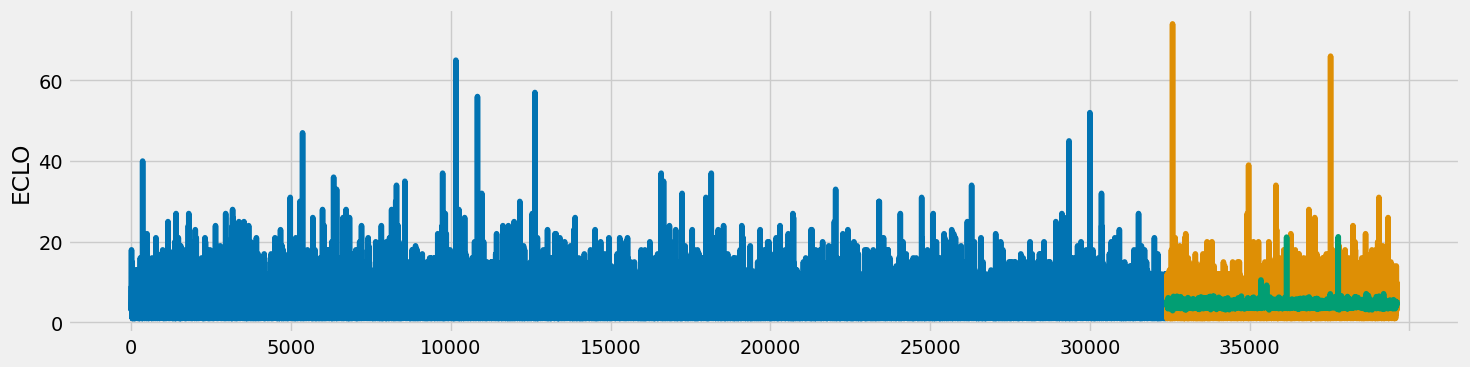

In [ ]:
## 주황색이 실제 전력소비량, 초록색이 예측값입니다.
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('rmsle : {:.6f}'.format(np.sqrt(mean_squared_log_error(y_valid, y_pred))))

## 🏄🏻‍♀️ Tensorflow

In [9]:
import tensorflow as tf

In [10]:
tf.__version__

'2.14.0'

#### Computatinal Graph

In [6]:
# 1. 그래프 빌드업
node1 = tf.constant(3.0, tf.float32)
node2 = tf.constant(4.0)
node3 = tf.add(node1, node2)  #node3 = node1 + node2 라고도 표현 가능

print("node1:", node1, "node2:", node2)
print("node3:", node3)

node1: tf.Tensor(3.0, shape=(), dtype=float32) node2: tf.Tensor(4.0, shape=(), dtype=float32)
node3: tf.Tensor(7.0, shape=(), dtype=float32)


In [12]:
@tf.function
def adder(a,b):
  return a+b

a = tf.constant([1,3])
b = tf.constant([2,4])

print(adder(a,b))

tf.Tensor([3 7], shape=(2,), dtype=int32)


In [ ]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [ ]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100, batch_size=128,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
279/279 [==============================] - 2s 3ms/step - loss: 0.5941 - metric_fn: 0.5940 - val_loss: 3.1377 - val_metric_fn: 3.1377 - lr: 0.0010
Epoch 2/100
279/279 [==============================] - 1s 2ms/step - loss: 0.4582 - metric_fn: 0.4580 - val_loss: 0.8491 - val_metric_fn: 0.8490 - lr: 0.0010
Epoch 3/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4543 - metric_fn: 0.4543 - val_loss: 0.4494 - val_metric_fn: 0.4493 - lr: 0.0010
Epoch 4/100
279/279 [==============================] - 1s 3ms/step - loss: 0.4523 - metric_fn: 0.4524 - val_loss: 0.4408 - val_metric_fn: 0.4408 - lr: 0.0010
Epoch 5/100
279/279 [==============================] - 1s 4ms/step - loss: 0.4507 - metric_fn: 0.4507 - val_loss: 0.4354 - val_metric_fn: 0.4353 - lr: 0.0010
Epoch 6/100
279/279 [==============================] - 1s 4ms/step - loss: 0.4497 - metric_fn: 0.4497 - val_loss: 0.4364 - val_metric_fn: 0.4363 - lr: 0.0010
Epoch 7/100
279/279 [==============================]

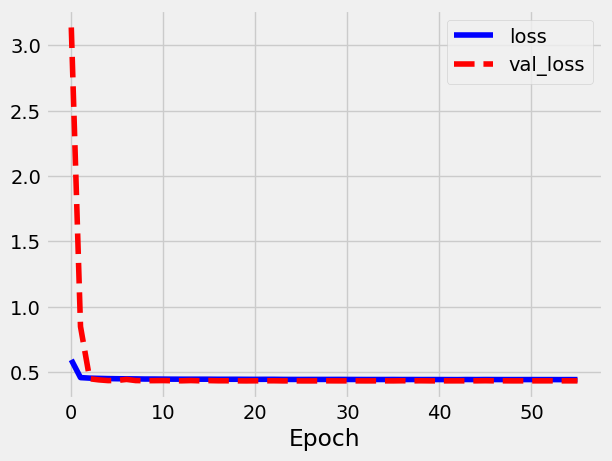

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
sub = pd.read_csv(path3)
sub["ECLO"] = model.predict(test_x.astype('float32'))
sub.to_csv("tensorflow_2.csv", index=False)
sub

343/343 [==============================] - 1s 2ms/step


,ID,ECLO
0,ACCIDENT_39609,5.865693
1,ACCIDENT_39610,5.922255
2,ACCIDENT_39611,7.064700
3,ACCIDENT_39612,6.467892
4,ACCIDENT_39613,6.934819
...,...,...
10958,ACCIDENT_50567,5.915889
10959,ACCIDENT_50568,6.460255
10960,ACCIDENT_50569,6.439847
10961,ACCIDENT_50570,5.564263


원핫인코딩, 안개->기타 변경, 동 삭제
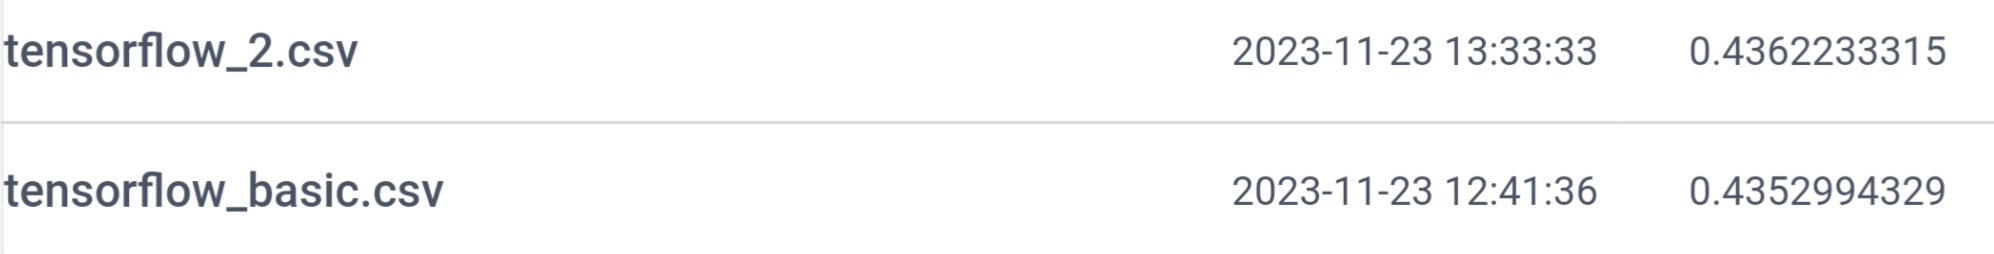